In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import Row
import logging
#from preprocessing import preprocess
#from src.app.utils import read_file, unzip_file, check_delimiter
#from utils import read_file, unzip_file, check_delimiter
from functools import reduce


#NEW IMPORTS
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt 





# Configura el nivel de registro de log para Spark
log = logging.getLogger("pyspark")
log.setLevel(logging.ERROR)
spark = SparkSession.builder \
        .config("spark.jars", "postgresql-42.6.0.jar") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "8") \
        .config("spark.cores.max", "8") \
        .master('local[4]') \
        .getOrCreate()

In [2]:
# Leer un archivo CSV y crear un DataFrame
df = spark.read.csv('dataOneHot.csv', header=True, inferSchema=True)

# Mostrar los primeros registros del DataFrame
df.show()

+----+-----+----------+---------+-------+----------+---------+--------------+--------+--------+--------+-------+-----+----------+--------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSArrTime|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|index|Origin_cat|Dest_cat|
+----+-----+----------+---------+-------+----------+---------+--------------+--------+--------+--------+-------+-----+----------+--------+
|2008|    1|        12|        6|   1018|      1505|      304|           170|      -9|       3|    1242|      8|    0|       4.0|    42.0|
|2008|    1|         6|        7|   2007|      2141|      145|            87|      -6|      -7|     334|     26|    1|       1.0|    12.0|
|2008|    1|         9|        3|   1445|      1510|     1025|            40|      15|      15|     163|      6|    2|      89.0|    35.0|
|2008|    1|        17|        4|    544|       821|      899|           151|       0|      -6|     752|     21|    3|      16.0|    21.0|
|2008|    1|         6|    

In [3]:
# Summary statistics for quantitative columns
summary = df.describe()
summary.show()
print ('numero de columnas')
len(df.columns)


+-------+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|summary|   Year|             Month|       DayofMonth|         DayOfWeek|           DepTime|        CRSArrTime|         FlightNum|    CRSElapsedTime|         ArrDelay|          DepDelay|         Distance|           TaxiOut|               index|        Origin_cat|          Dest_cat|
+-------+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+------------------+------------------+
|  count|2319121|           2319121|          2319121|           2319121|           2319121|           2319121|           2319121|           2319121|  

15

# EL códido empieza a partir de aquí

In [4]:
#Function for spliting the dataframe into 70% for train and 30% for test
def split_train_test(dataframe, train_ratio):
    # Randomly split into train and test
    splits = dataframe.randomSplit([train_ratio, 1.0 - train_ratio], seed=7)
    
    # Obtain the dataframes od train and test
    df_train = splits[0]
    df_test = splits[1]
    
    return df_train, df_test

# Split the DataFrame into train and test sets
df_train, df_test = split_train_test(df, train_ratio=0.7)

# Check the sizes of the resulting DataFrames
print("Training set size:", df_train.count())
print("Test set size:", df_test.count())

Training set size: 1622952
Test set size: 696169


In [5]:
#Function for the vector assembler and creating a vector for all the individual features
def vector_assembler(dataframe):
    # List of features excluding the target variable 'ArrDelay'
    feature_cols = [col for col in dataframe.columns if col != 'ArrDelay']

    # Vector Assembler excluding 'ArrDelay'
    #assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    assembler=VectorAssembler().setInputCols(feature_cols).setOutputCol('features')

    # Apply the assembler to the DataFrame
    a_df = assembler.transform(dataframe)
    b_df = a_df.select("features",a_df.ArrDelay.alias('label'))
    
    return b_df

# Assembled train and test sets
Adf_train = vector_assembler(df_train)
Adf_test = vector_assembler(df_test)

# Show dfs
Adf_train.show(truncate=False)
Adf_test.show(truncate=False)

feature_cols = [col for col in df.columns if col != 'ArrDelay']

+---------------------------------------------------------------------------------------+-----+
|features                                                                               |label|
+---------------------------------------------------------------------------------------+-----+
|[2008.0,1.0,1.0,2.0,1.0,2235.0,106.0,105.0,251.0,611.0,7.0,48655.0,23.0,18.0]          |233  |
|[2008.0,1.0,1.0,2.0,3.0,40.0,1100.0,150.0,173.0,997.0,9.0,1.717991453E10,23.0,25.0]    |163  |
|[2008.0,1.0,1.0,2.0,5.0,823.0,172.0,308.0,-10.0,2521.0,10.0,1.7179909995E10,40.0,16.0] |-19  |
|[2008.0,1.0,1.0,2.0,5.0,2346.0,260.0,79.0,98.0,334.0,10.0,41230.0,1.0,12.0]            |86   |
|[2008.0,1.0,1.0,2.0,8.0,2340.0,174.0,60.0,148.0,229.0,8.0,8.589996506E9,23.0,8.0]      |140  |
|[2008.0,1.0,1.0,2.0,13.0,620.0,1804.0,265.0,18.0,2116.0,12.0,1.7179892771E10,57.0,10.0]|8    |
|[2008.0,1.0,1.0,2.0,14.0,535.0,1608.0,235.0,34.0,1846.0,11.0,22423.0,13.0,1.0]         |35   |
|[2008.0,1.0,1.0,2.0,18.0,709.0,1860.0,2

In [6]:
#Function for evaluating a regression model
def reg_evaluator(test_dt): 
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
    metrics = ["r2", "mse", "rmse", "mae"]
    metric_values = [evaluator.evaluate(test_dt, {evaluator.metricName: metric}) for metric in metrics]

    # Obtain a dataframe with those results
    metric_df = spark.createDataFrame(zip(metrics, metric_values), ["Metric", "Value"])
    return metric_df

In [7]:
#Function for obtaining the hyper-parameters from the best model obtained
def best_hyperparams(model, param_names):
    for param_name in param_names:
        param = model.getOrDefault(param_name)
        print(f"Best {param_name}: {param}")

In [8]:
# Function for getting the feature importances of a model
def plot_feature_importances(model, feature_cols, plot_title):
    var_importances = model.featureImportances

    feature_imp_list = [(feature_cols[i], var_importances[i]) for i in range(len(feature_cols))]
    sorted_imp = sorted(feature_imp_list, key=lambda x: x[1], reverse=True)

    for feature, importance in sorted_imp:
        print(f"Feature: {feature}, Importance: {importance}")

    features, importance_values = zip(*sorted_imp)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(features)), importance_values, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.title(plot_title)
    plt.show()

# Decision Tree

In [108]:
# Building a decision tree model for regression
def reg_tree(df_train):
    dtr = DecisionTreeRegressor()
    model = dtr.fit(df_train)
    return model

#test the model
dtr_model = reg_tree(Adf_train)
test_dtr = dtr_model.transform(Adf_test)
test_dtr.show(truncate=False)

+--------------------------------------------------------------+-----+------------------+
|features                                                      |label|prediction        |
+--------------------------------------------------------------+-----+------------------+
|[2008.0,1.0,1.0,2.0,2.0,532.0,380.0,217.0,7.0,1703.0,8.0]     |-3   |0.751982266707233 |
|[2008.0,1.0,1.0,2.0,3.0,40.0,1100.0,150.0,173.0,997.0,9.0]    |163  |153.93965517241378|
|[2008.0,1.0,1.0,2.0,3.0,2315.0,2895.0,210.0,198.0,1241.0,25.0]|195  |229.3850766155896 |
|[2008.0,1.0,1.0,2.0,4.0,520.0,878.0,201.0,5.0,1589.0,19.0]    |-1   |0.751982266707233 |
|[2008.0,1.0,1.0,2.0,4.0,2255.0,2449.0,60.0,129.0,258.0,18.0]  |135  |229.3850766155896 |
|[2008.0,1.0,1.0,2.0,5.0,823.0,172.0,308.0,-10.0,2521.0,10.0]  |-19  |-8.20378273393664 |
|[2008.0,1.0,1.0,2.0,5.0,2346.0,260.0,79.0,98.0,334.0,10.0]    |86   |229.3850766155896 |
|[2008.0,1.0,1.0,2.0,6.0,505.0,240.0,190.0,11.0,1447.0,13.0]   |2    |7.146633065697708 |
|[2008.0,1

In [109]:
# Evaluate the model
print('Evaluating the Regression Tree Model:')
dtr_evaluation = reg_evaluator(test_dtr)
dtr_evaluation.show()

Evaluating the Regression Tree Model:
+------+------------------+
|Metric|             Value|
+------+------------------+
|    r2|0.7824781003899991|
|   mse| 336.9805746816155|
|  rmse| 18.35703066080175|
|   mae|10.144288622285625|
+------+------------------+



In [113]:
# Obtain the decision tree
tree_structure = dtr_model.toDebugString
print("Regression tree model:")
print(tree_structure)
names_df = spark.createDataFrame([(f'feature {idx}', col) for idx, col in enumerate(feature_cols)], ["Feature Position", "Feature Name"])
names_df.show()

Learned regression tree model:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_d501a076fe58, depth=5, numNodes=63, numFeatures=11
  If (feature 8 <= 60.5)
   If (feature 8 <= 14.5)
    If (feature 10 <= 29.5)
     If (feature 8 <= 1.5)
      If (feature 10 <= 17.5)
       Predict: -8.20378273393664
      Else (feature 10 > 17.5)
       Predict: -1.627719247857892
     Else (feature 8 > 1.5)
      If (feature 8 <= 7.5)
       Predict: 0.751982266707233
      Else (feature 8 > 7.5)
       Predict: 7.146633065697708
    Else (feature 10 > 29.5)
     If (feature 10 <= 41.5)
      If (feature 8 <= 1.5)
       Predict: 7.586224709427465
      Else (feature 8 > 1.5)
       Predict: 18.37726871048875
     Else (feature 10 > 41.5)
      If (feature 10 <= 125.0)
       Predict: 29.951456958058277
      Else (feature 10 > 125.0)
       Predict: 135.32682926829267
   Else (feature 8 > 14.5)
    If (feature 8 <= 30.5)
     If (feature 10 <= 35.5)
      If (feature 8 <= 22.5)
       Predict: 

# Decision Tree with CV

In [13]:
# Function for training a decision tree model for regression using k-fold (k=5) cross validation to find the best hyperparameters
def CVreg_tree(df_train):
    dtr = DecisionTreeRegressor()
    # Define a grid of hyperparameters to search through
    hyperparamGrid = (
        ParamGridBuilder()
        .addGrid(dtr.maxDepth, [3, 5, 7, 10])  #default = 5
        .addGrid(dtr.maxBins, [32, 35, 40]) #default = 32
        .addGrid(dtr.minInstancesPerNode, [1, 3, 5, 7]) #default = 1
        .addGrid(dtr.minInfoGain, [0.0, 0.2]) #default = 0.0
        .build()
    )

    # Define an evaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    # Create a k-fold CrossValidator with k=5
    crossval = CrossValidator(
        estimator=dtr,
        estimatorParamMaps=hyperparamGrid,
        evaluator=evaluator,
        numFolds=5,
        seed=7
    )
    cvModel = crossval.fit(df_train)

    # The best model from cross-validation
    best_model = cvModel.bestModel

    return best_model

#test the model
dtr_CVmodel = CVreg_tree(Adf_train)
test_CVdtr = dtr_CVmodel.transform(Adf_test)
test_CVdtr.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+--------------------+
|features                                                                               |label|prediction          |
+---------------------------------------------------------------------------------------+-----+--------------------+
|[2008.0,1.0,1.0,2.0,4.0,2359.0,4386.0,109.0,174.0,599.0,12.0,24493.0,1.0,14.0]         |162  |189.8628762541806   |
|[2008.0,1.0,1.0,2.0,8.0,49.0,859.0,184.0,143.0,1028.0,32.0,1.7179927526E10,15.0,54.0]  |163  |152.5               |
|[2008.0,1.0,1.0,2.0,9.0,652.0,1076.0,237.0,14.0,1910.0,18.0,1.7179899622E10,7.0,45.0]  |23   |9.593839541547277   |
|[2008.0,1.0,1.0,2.0,13.0,750.0,58.0,303.0,26.0,2248.0,14.0,1.7179910644E10,7.0,16.0]   |11   |14.233382570162481  |
|[2008.0,1.0,1.0,2.0,14.0,219.0,19.0,146.0,21.0,762.0,38.0,8.589964081E9,7.0,38.0]      |20   |40.5945945945946    |
|[2008.0,1.0,1.0,2.0,14.0,2350.0,1831.0,60.0,84.0,204.0,14.0,1.7

In [14]:
# Evaluate the model
print('Evaluating the Regression Tree Model:')
CVdtr_evaluation = reg_evaluator(test_CVdtr)
CVdtr_evaluation.show()

Evaluating the Regression Tree Model:
+------+------------------+
|Metric|             Value|
+------+------------------+
|    r2|0.8665471072371965|
|   mse| 213.5896805328834|
|  rmse|14.614707678666836|
|   mae| 8.719389335114059|
+------+------------------+



In [15]:
# Obtain the decision tree
CVtree_structure = dtr_CVmodel.toDebugString
print("Regression tree model:")
print(CVtree_structure)
names_df = spark.createDataFrame([(f'feature {idx}', col) for idx, col in enumerate(feature_cols)], ["Feature Position", "Feature Name"])
names_df.show()

Regression tree model:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_ff8c1968108d, depth=10, numNodes=1867, numFeatures=14
  If (feature 8 <= 56.5)
   If (feature 8 <= 14.5)
    If (feature 10 <= 29.5)
     If (feature 8 <= 1.5)
      If (feature 10 <= 17.5)
       If (feature 8 <= -4.5)
        If (feature 8 <= -8.5)
         If (feature 10 <= 12.5)
          If (feature 8 <= -10.5)
           If (feature 10 <= 9.5)
            Predict: -18.26110249541802
           Else (feature 10 > 9.5)
            Predict: -16.220807726075506
          Else (feature 8 > -10.5)
           If (feature 12 <= 30.5)
            Predict: -16.569738087724833
           Else (feature 12 > 30.5)
            Predict: -13.494923629829291
         Else (feature 10 > 12.5)
          If (feature 12 <= 30.5)
           If (feature 13 <= 7.5)
            Predict: -12.204529370134466
           Else (feature 13 > 7.5)
            Predict: -14.555555555555555
          Else (feature 12 > 30.5)
           I

Feature: DepDelay, Importance: 0.8654684784596999
Feature: TaxiOut, Importance: 0.05044242851884485
Feature: DepTime, Importance: 0.039357596912844704
Feature: CRSArrTime, Importance: 0.03347456068906483
Feature: Origin_cat, Importance: 0.0051579627855640195
Feature: CRSElapsedTime, Importance: 0.0031053445751868898
Feature: Distance, Importance: 0.0014938645966788074
Feature: Dest_cat, Importance: 0.000474287747434532
Feature: FlightNum, Importance: 0.0003537755574505821
Feature: DayOfWeek, Importance: 0.00028328577783769945
Feature: index, Importance: 0.00016990604313959462
Feature: DayofMonth, Importance: 0.000154045836980898
Feature: Month, Importance: 6.446249927285699e-05
Feature: Year, Importance: 0.0


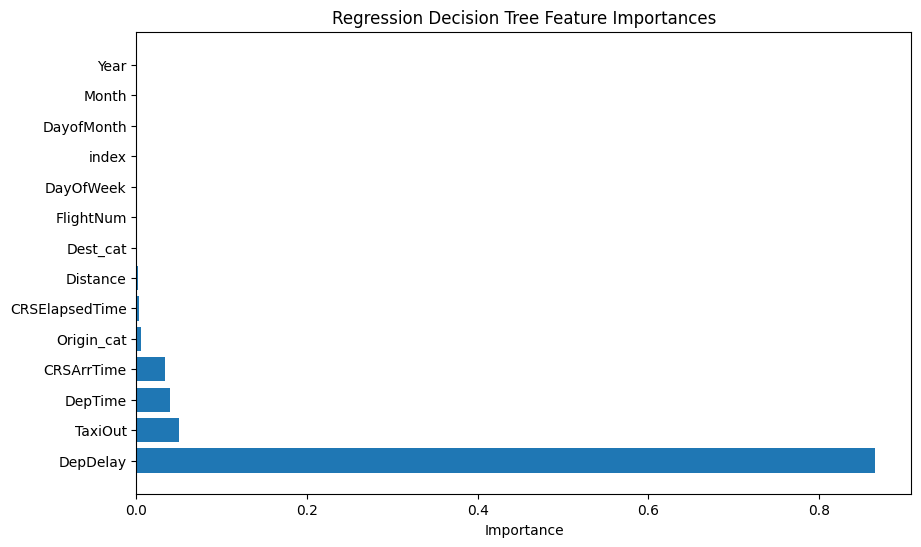

In [16]:
# Get the feature importances
plot_feature_importances(dtr_CVmodel, feature_cols, plot_title='Regression Decision Tree Feature Importances')

In [17]:
# Obtain the best hyperparameters
'''
best_maxDepth = dtr_CVmodel.getOrDefault("maxDepth")
best_maxBins = dtr_CVmodel.getOrDefault("maxBins")
best_minInstancesPerNode = dtr_CVmodel.getOrDefault("minInstancesPerNode")
best_minInfoGain = dtr_CVmodel.getOrDefault("minInfoGain")
 
print("Best maxDepth:", best_maxDepth)
print("Best maxBins:", best_maxBins)
print("Best minInstancesPerNode:", best_minInstancesPerNode)
print("Best minInfoGain:", best_minInfoGain)
'''
print("Best Hyper-Parameters of Decision Tree")
dtr_param_names = ["maxDepth", "maxBins", "minInstancesPerNode", "minInfoGain"]
best_hyperparams(dtr_CVmodel, dtr_param_names)

Best Hyper-Parameters of Decision Tree
Best maxDepth: 10
Best maxBins: 40
Best minInstancesPerNode: 3
Best minInfoGain: 0.0


# Random Forest

In [15]:
# Building a random forest model for regression
def random_forest(df_train):
    rf = RandomForestRegressor()
    model = rf.fit(df_train)
    return model

#test the model
rf_model = random_forest(Adf_train)
test_rf = rf_model.transform(Adf_test)
test_rf.show(truncate=False)

+--------------------------------------------------------------+-----+-------------------+
|features                                                      |label|prediction         |
+--------------------------------------------------------------+-----+-------------------+
|[2008.0,1.0,1.0,2.0,2.0,532.0,380.0,217.0,7.0,1703.0,8.0]     |-3   |-1.2971905110936264|
|[2008.0,1.0,1.0,2.0,3.0,40.0,1100.0,150.0,173.0,997.0,9.0]    |163  |146.19880345469505 |
|[2008.0,1.0,1.0,2.0,3.0,2315.0,2895.0,210.0,198.0,1241.0,25.0]|195  |198.9674458294707  |
|[2008.0,1.0,1.0,2.0,4.0,520.0,878.0,201.0,5.0,1589.0,19.0]    |-1   |1.8182312367837024 |
|[2008.0,1.0,1.0,2.0,4.0,2255.0,2449.0,60.0,129.0,258.0,18.0]  |135  |185.05932351962315 |
|[2008.0,1.0,1.0,2.0,5.0,823.0,172.0,308.0,-10.0,2521.0,10.0]  |-19  |-4.195233282920877 |
|[2008.0,1.0,1.0,2.0,5.0,2346.0,260.0,79.0,98.0,334.0,10.0]    |86   |187.62968816159727 |
|[2008.0,1.0,1.0,2.0,6.0,505.0,240.0,190.0,11.0,1447.0,13.0]   |2    |-0.9626066997285229|

In [16]:
# Evaluate the model
print('Evaluating the Regression Tree Model:')
rf_evaluation = reg_evaluator(test_rf)
rf_evaluation.show()

Evaluating the Regression Tree Model:
+------+------------------+
|Metric|             Value|
+------+------------------+
|    r2|0.7428441170356701|
|   mse|398.38074869448235|
|  rmse| 19.95947766587298|
|   mae| 11.22121365111875|
+------+------------------+



In [23]:
# Get the feature importances
varImportances = rf_model.featureImportances

# Pair feature names with importances and sort them
feature_importance_list = [(feature_cols[i], varImportances[i]) for i in range(len(feature_cols))]
sorted_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Show result
for feature, importance in sorted_importance:
    print(f"Feature: {feature}, Importance: {importance}")

# Extract feature names and importances for plotting
features, importance_values = zip(*sorted_importance)
# Bar chart of the variable importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Feature Importances')

plt.show()


NameError: name 'rf_model' is not defined

# Ranfom Forest with CV

In [19]:
# Building a random forest model for regression using k-fold (k=5) cross validation to find the best hyperparameters
def CVrandom_forest(df_train):
    rf = RandomForestRegressor()
    # Define a grid of hyperparameters to search
    hyperparamGrid = (
        ParamGridBuilder() 
        .addGrid(rf.numTrees, [10, 20, 35]) #default = 20
        .addGrid(rf.maxDepth, [10])  #default = 5, it was chosen the best hyper-parameter from the decision tree
        .addGrid(rf.maxBins, [40]) #default = 32, it was chosen the best hyper-parameter from the decision tree
        .addGrid(rf.subsamplingRate, [0.6, 0.8, 1.0]) #default = 1
        .addGrid(rf.minInstancesPerNode, [5]) #default = 1, it was chosen the best hyper-parameter from the decision tree
        .addGrid(rf.minInfoGain, [0.0]) #default = 0.0, it was chosen the best hyper-parameter from the decision tree
        .build()
    )
    # Evaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    # K-fold CrossValidator
    crossval = CrossValidator(
        estimator=rf,
        estimatorParamMaps=hyperparamGrid,
        evaluator=evaluator,
        numFolds=5,
        seed=7
    )  
    cvModel = crossval.fit(df_train)

    # The best model from cross-validation
    best_model = cvModel.bestModel

    return best_model

#test the model
rf_CVmodel = CVrandom_forest(Adf_train)
test_CVrf = rf_CVmodel.transform(Adf_test)
test_CVrf.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+-------------------+
|features                                                                               |label|prediction         |
+---------------------------------------------------------------------------------------+-----+-------------------+
|[2008.0,1.0,1.0,2.0,4.0,2359.0,4386.0,109.0,174.0,599.0,12.0,24493.0,1.0,14.0]         |162  |215.61620288271283 |
|[2008.0,1.0,1.0,2.0,8.0,49.0,859.0,184.0,143.0,1028.0,32.0,1.7179927526E10,15.0,54.0]  |163  |181.15981064974977 |
|[2008.0,1.0,1.0,2.0,9.0,652.0,1076.0,237.0,14.0,1910.0,18.0,1.7179899622E10,7.0,45.0]  |23   |13.166853538552692 |
|[2008.0,1.0,1.0,2.0,13.0,750.0,58.0,303.0,26.0,2248.0,14.0,1.7179910644E10,7.0,16.0]   |11   |18.213601098363338 |
|[2008.0,1.0,1.0,2.0,14.0,219.0,19.0,146.0,21.0,762.0,38.0,8.589964081E9,7.0,38.0]      |20   |45.710738338969534 |
|[2008.0,1.0,1.0,2.0,14.0,2350.0,1831.0,60.0,84.0,204.0,14.0,1.717992632

In [20]:
# Evaluate the model
print('Evaluating the Ranfom Forest Model:')
CVrf_evaluation = reg_evaluator(test_CVrf)
CVrf_evaluation.show()

Evaluating the Ranfom Forest Model:
+------+------------------+
|Metric|             Value|
+------+------------------+
|    r2|0.8545012172597083|
|   mse|232.86897631104947|
|  rmse|15.260045095315068|
|   mae| 8.975188125763324|
+------+------------------+



Feature: DepDelay, Importance: 0.7948913145828242
Feature: TaxiOut, Importance: 0.07761786923913547
Feature: DepTime, Importance: 0.06385735476361601
Feature: CRSArrTime, Importance: 0.038565558261440515
Feature: Origin_cat, Importance: 0.0071207086097886865
Feature: Distance, Importance: 0.005973254200244048
Feature: CRSElapsedTime, Importance: 0.003849908052578812
Feature: Dest_cat, Importance: 0.003301732449364958
Feature: FlightNum, Importance: 0.001585212431911978
Feature: DayofMonth, Importance: 0.0012761460799407475
Feature: index, Importance: 0.0009718897914346537
Feature: DayOfWeek, Importance: 0.0005067400285598216
Feature: Month, Importance: 0.00048231150916011264
Feature: Year, Importance: 0.0


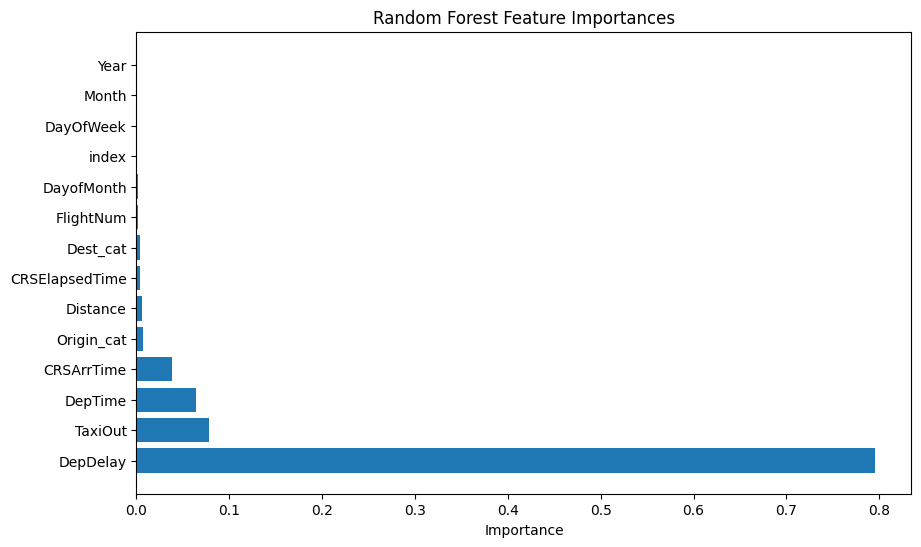

In [21]:
# Get the feature importances
plot_feature_importances(rf_CVmodel, feature_cols, plot_title='Random Forest Feature Importances')

In [22]:
# Obtain the best hyperparameters
'''
rfbest_numTrees = rf_CVmodel.getOrDefault("numTrees")
rfbest_maxDepth = rf_CVmodel.getOrDefault("maxDepth")
rfbest_maxBins = rf_CVmodel.getOrDefault("maxBins")
rfbest_subsamplingRate = rf_CVmodel.getOrDefault("subsamplingRate")
rfbest_minInstancesPerNode = rf_CVmodel.getOrDefault("minInstancesPerNode")
rfbest_minInfoGain = rf_CVmodel.getOrDefault("minInfoGain")

print("Best numTrees:", rfbest_numTrees)
print("Best maxDepth:", rfbest_maxDepth)
print("Best maxBins:", rfbest_maxBins)
print("Best subsamplingRate:", rfbest_subsamplingRate)
print("Best minInstancesPerNode:", rfbest_minInstancesPerNode)
print("Best minInfoGain:", rfbest_minInfoGain)
'''
print("Best Hyper-Parameters of Random Forest")
rf_param_names = ["numTrees","maxDepth","maxBins","subsamplingRate","minInstancesPerNode","minInfoGain"]
best_hyperparams(rf_CVmodel, rf_param_names)

Best Hyper-Parameters of Random Forest
Best numTrees: 10
Best maxDepth: 10
Best maxBins: 40
Best subsamplingRate: 0.8
Best minInstancesPerNode: 5
Best minInfoGain: 0.0


# AdaBoost with CV

In [23]:
# Building an AdaBoost model for regression using k-fold (k=5) cross validation to find the best hyperparameters 
def CVadaboost(df_train):
    ab = GBTRegressor(maxDepth=1)  # In AdaBoost each tree is a stump(1 root node and 2 leafs nodes)
    # Define a grid of hyperparameters to search
    hyperparamGrid = (
        ParamGridBuilder() 
        .addGrid(ab.maxIter, [10, 20, 35, 50])  #default = 20
        .addGrid(ab.stepSize, [0.1, 0.2, 0.3])  #default = 0.1
        .build()
    )
    # Evaluator
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    # K-fold CrossValidator
    crossval = CrossValidator(
        estimator=ab,
        estimatorParamMaps=hyperparamGrid,
        evaluator=evaluator,
        numFolds=5,
        seed=7
    )  
    cvModel = crossval.fit(df_train)

    # The best model from cross-validation
    best_model = cvModel.bestModel

    return best_model

#test the model
ab_CVmodel = CVadaboost(Adf_train)
test_CVab = ab_CVmodel.transform(Adf_test)
test_CVab.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+-------------------+
|features                                                                               |label|prediction         |
+---------------------------------------------------------------------------------------+-----+-------------------+
|[2008.0,1.0,1.0,2.0,4.0,2359.0,4386.0,109.0,174.0,599.0,12.0,24493.0,1.0,14.0]         |162  |158.4704178818473  |
|[2008.0,1.0,1.0,2.0,8.0,49.0,859.0,184.0,143.0,1028.0,32.0,1.7179927526E10,15.0,54.0]  |163  |168.60931427410824 |
|[2008.0,1.0,1.0,2.0,9.0,652.0,1076.0,237.0,14.0,1910.0,18.0,1.7179899622E10,7.0,45.0]  |23   |15.825520885613205 |
|[2008.0,1.0,1.0,2.0,13.0,750.0,58.0,303.0,26.0,2248.0,14.0,1.7179910644E10,7.0,16.0]   |11   |16.80215095362837  |
|[2008.0,1.0,1.0,2.0,14.0,219.0,19.0,146.0,21.0,762.0,38.0,8.589964081E9,7.0,38.0]      |20   |45.9515944790048   |
|[2008.0,1.0,1.0,2.0,14.0,2350.0,1831.0,60.0,84.0,204.0,14.0,1.717992632

In [24]:
# Evaluate the model
print('Evaluating the AdaBoost Model:')
CVab_evaluation = reg_evaluator(test_CVab)
CVab_evaluation.show()

Evaluating the AdaBoost Model:
+------+------------------+
|Metric|             Value|
+------+------------------+
|    r2|0.7777605632868918|
|   mse|355.69143018675135|
|  rmse|18.859783407736987|
|   mae| 9.564911979611718|
+------+------------------+



Feature: DepDelay, Importance: 0.8592078860512091
Feature: TaxiOut, Importance: 0.13062738520281109
Feature: Origin_cat, Importance: 0.005571578368073121
Feature: CRSElapsedTime, Importance: 0.0029335910557870435
Feature: Dest_cat, Importance: 0.000895096996007208
Feature: CRSArrTime, Importance: 0.0007644623261123222
Feature: Year, Importance: 0.0
Feature: Month, Importance: 0.0
Feature: DayofMonth, Importance: 0.0
Feature: DayOfWeek, Importance: 0.0
Feature: DepTime, Importance: 0.0
Feature: FlightNum, Importance: 0.0
Feature: Distance, Importance: 0.0
Feature: index, Importance: 0.0


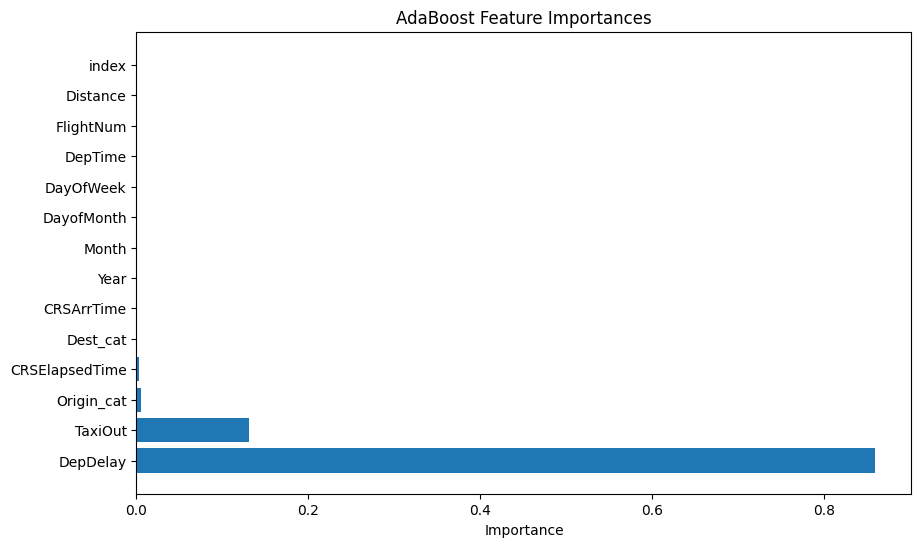

In [25]:
# Get the feature importances
plot_feature_importances(ab_CVmodel, feature_cols, plot_title='AdaBoost Feature Importances')

In [27]:
# Obtain the best hyperparameters
print("Best Hyper-Parameters of AdaBoost")
ab_param_names = ["maxDepth","maxIter","stepSize"]
best_hyperparams(ab_CVmodel, ab_param_names)

Best Hyper-Parameters of AdaBoost
Best maxDepth: 1
Best maxIter: 50
Best stepSize: 0.3
